Inspiration from Thu Vu https://github.com/thu-vu92/youtube-api-analysis

In [1]:
#data manipulation
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#sns.color_palette('colorblind')
%matplotlib inline

#NLP lib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')
from wordcloud import WordCloud

In [2]:
day_order = 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()

In [3]:
use_palette = 'magma'

## Reading and Data Preparation/Feature Engineering for channel data

In [4]:
ch_df = pd.read_csv('channel_df.csv')

In [5]:
ch_df.drop('Unnamed: 0',axis=1,inplace=True)

In [72]:
#change published date to the correct datatype
ch_df['channel_pub_date'] =  ch_df['channel_pub_date'].apply(lambda x: parser.parse(x))

ch_df['channel_pub_year'] = ch_df['channel_pub_date'].apply(lambda x: x.strftime("%Y"))

In [74]:
#selecting columns to convert to numeric
cols_to_numeric = ['channel_view','channel_sub','channel_video','channel_pub_year']

In [7]:
#convert datatypes to numeric
ch_df[cols_to_numeric] = ch_df[cols_to_numeric].apply(pd.to_numeric,errors='coerce')

In [9]:
#create view per video channel
ch_df['view_per_video'] = ch_df['channel_view'] / ch_df['channel_video']

In [10]:
#fill missing description
ch_df['channel_desc'].fillna('No Description',inplace=True)

In [11]:
#fill missing location
ch_df['channel_loc'].fillna('No Location',inplace=True)

We can separate our analysis by channel type based on numbers of subscribers

__Premium tier (sub > 100,000)__ 
- Zak George's Dog Training Revolution
- Dog Training by Kikopup

__Medium tier (10,000 < sub <= 100,000)__
- absoluteDogs
- Dogs That

__Low tier (sub <= 10,000)__
- The rest

In [12]:
#sorting channel tier
def channel_tier(subs):
    if subs > 100000:
        return "high"
    elif subs > 10000:
        return "medium"
    else:
        return "low"

In [13]:
ch_df['channel_tier'] = ch_df['channel_sub'].apply(lambda x : channel_tier(x))

<AxesSubplot:>

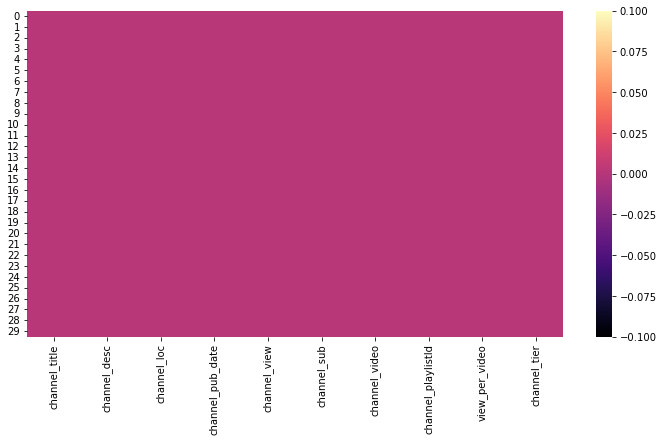

In [14]:
#showing that data is complete and in correct format
plt.figure(figsize=(12,6))
sns.heatmap(ch_df.isnull(),cmap='magma')

In [15]:
ch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype                  
---  ------              --------------  -----                  
 0   channel_title       30 non-null     object                 
 1   channel_desc        30 non-null     object                 
 2   channel_loc         30 non-null     object                 
 3   channel_pub_date    30 non-null     datetime64[ns, tzutc()]
 4   channel_view        30 non-null     int64                  
 5   channel_sub         30 non-null     int64                  
 6   channel_video       30 non-null     int64                  
 7   channel_playlistId  30 non-null     object                 
 8   view_per_video      30 non-null     float64                
 9   channel_tier        30 non-null     object                 
dtypes: datetime64[ns, tzutc()](1), float64(1), int64(3), object(5)
memory usage: 2.5+ KB


## Reading and Data Preparation/Feature Engineering for video Data Frame

In [16]:
video_df = pd.read_csv('video_df.csv')

In [121]:
#applying parser
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x))

#feature engineering day and month
video_df['publishedDay'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))
video_df['publishedMonth'] = video_df['publishedAt'].apply(lambda x: x.strftime("%m"))
video_df['publishedYear'] = video_df['publishedAt'].apply(lambda x: x.strftime("%Y"))

In [18]:
#converting datatypes to numeric
num_cols = ['viewCount', 'likeCount','commentCount','publishedMonth']
video_df[num_cols] = video_df[num_cols].apply(pd.to_numeric, errors='coerce')

In [19]:
#applying parser
video_df['duration_sec'] = video_df['duration'].apply(lambda x : isodate.parse_duration(x))

#feature enginineering seconds and minutes (rounded)
video_df['duration_sec'] = video_df['duration_sec'].astype('timedelta64[s]')
video_df['duration_min'] = video_df['duration_sec'].apply(lambda x : round(x/60))

In [20]:
#input list brackets into empty tags columns
video_df['tags'].fillna("[]",inplace=True)

In [21]:
#converting tags to list
video_df['tags_list'] = video_df['tags'].apply(lambda x : x.strip("[]").replace("'","").split(', '))

#feature engineering tags count
video_df['tags_count'] = video_df['tags_list'].apply(lambda x : len(x))

In [22]:
#feature engineering like and comments ratio
video_df['likeRatio'] = video_df['likeCount'] / video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount'] / video_df['viewCount'] * 1000

In [23]:
#feature engineering title length
video_df['title_length'] = video_df['title'].apply(lambda x: len(x))

#### Check for missing data

In [24]:
video_df.isnull().sum() / len(video_df['video_id']) * 100

video_id          0.000000
channelTitle      0.000000
title             0.000000
description       4.602843
tags              0.000000
publishedAt       0.000000
duration          0.000000
definition        0.000000
caption           0.000000
viewCount         0.000000
likeCount         0.129861
favoriteCount     0.000000
commentCount      3.520670
publishedDay      0.000000
publishedMonth    0.000000
duration_sec      0.000000
duration_min      0.000000
tags_list         0.000000
tags_count        0.000000
likeRatio         0.165933
commentRatio      3.571171
title_length      0.000000
dtype: float64

In [25]:
#fill missing description
video_df['description'].fillna('No Description',inplace=True)

Drop missing data from columns that takes up < 5%

In [26]:
video_df.dropna(subset='likeCount',axis=0,inplace=True)
video_df.dropna(subset='commentCount',axis=0,inplace=True)
video_df.dropna(subset='commentRatio',axis=0,inplace=True)

<AxesSubplot:>

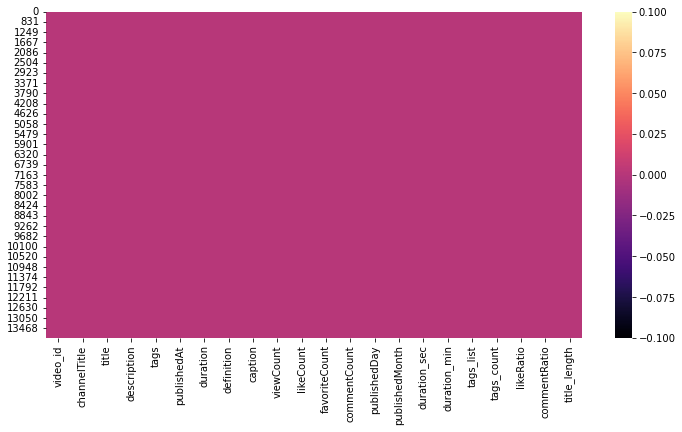

In [27]:
#showing that the data is complete and in correct format
plt.figure(figsize=(12,6))
sns.heatmap(video_df.isnull(),cmap='magma')

In [28]:
#this column is always empty, let's remove this
video_df.drop('favoriteCount',axis=1,inplace=True)

In [29]:
low_ch_title = list(ch_df[ch_df['channel_tier']=='low']['channel_title'])
medium_ch_title = list(ch_df[ch_df['channel_tier']=='medium']['channel_title'])
high_ch_title = list(ch_df[ch_df['channel_tier']=='high']['channel_title'])

In [30]:
low_ch_title

['McCann Dogs Agility',
 'Ogilvie Dogs',
 'OneMindDogs',
 'Agile Dog Training',
 'Jenny Damm',
 'Tereza Králová',
 'Fenrir Border Collie Show',
 'Iwona Golab',
 'Peak Performer',
 'Fanny Gott',
 'PointyFloppy']

In [31]:
video_df['channelTitle']

0        McCann Dogs Agility
1        McCann Dogs Agility
2        McCann Dogs Agility
3        McCann Dogs Agility
4        McCann Dogs Agility
                ...         
13856            Larry Krohn
13857            Larry Krohn
13858            Larry Krohn
13859            Larry Krohn
13860            Larry Krohn
Name: channelTitle, Length: 13349, dtype: object

In [32]:
def video_tier(channelTitle):
    if channelTitle in (high_ch_title):
        return 'high'
    elif channelTitle in medium_ch_title:
        return 'medium'
    else:
        return 'low'

In [33]:
video_df['channel_tier'] = video_df['channelTitle'].apply(lambda x : video_tier(x))

In [34]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13349 entries, 0 to 13860
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype                  
---  ------          --------------  -----                  
 0   video_id        13349 non-null  object                 
 1   channelTitle    13349 non-null  object                 
 2   title           13349 non-null  object                 
 3   description     13349 non-null  object                 
 4   tags            13349 non-null  object                 
 5   publishedAt     13349 non-null  datetime64[ns, tzutc()]
 6   duration        13349 non-null  object                 
 7   definition      13349 non-null  object                 
 8   caption         13349 non-null  bool                   
 9   viewCount       13349 non-null  int64                  
 10  likeCount       13349 non-null  float64                
 11  commentCount    13349 non-null  float64                
 12  publishedDay    13349 non-null  

## EDA : Channel

In [35]:
ch_df.sort_values(by='channel_sub',ascending=False)

channel_title  \
15  Zak George’s Dog Training Revolution   
27                   McCann Dog Training   
6                Dog Training by Kikopup   
3                      Training Positive   
18         Will Atherton Canine Training   
8                 Beckman's Dog Training   
19                        Stonnie Dennis   
1                     Fenrir Canine Show   
2              Peter Caine Dog Training    
29                           Larry Krohn   
7         BrightDog Academy Dog Training   
28                     Saro Dog Training   
17                          absoluteDogs   
10                             Dogs That   
11            Andy Krueger Dog Training    
21                  My Dog Training Spot   
14         The Canine Coach Dog Training   
16        Royvon Dog Training and Hotels   
25             Sarah Walsh - Dog Trainer   
20             Fenrir Border Collie Show   
24                            Fanny Gott   
5                            OneMindDogs   
13                        Tereza Králová   
12                            Jenny Damm   
0                    McCann Dogs Agility   
9                     Agile Dog Training   
4                           Ogilvie Dogs   
23                        Peak Performer   
22                           Iwona Golab   
26                          PointyFloppy   

                                         channel_desc  channel_loc  \
15  This is the official YouTube channel of me, do...           US   
27  At McCann Professional Dog Trainers, we train ...           CA   
6   Professional dog training videos created by wo...           US   
3   We produce educational dog training videos tha...           US   
18  Will Atherton Canine Training\nEducational and...           GB   
8   Joel and Liz started BDT in 2008 after leaving...  No Location   
19  This channel is devoted to providing a window ...           US   
1   FENRIR CANINE SHOW\nEducational and informativ...           GB   
2                                      No Description           US   
29  Professional dog trainer Larry Krohn, owner an...           US   
7   Learn how to train your dog or how to train yo...           US   
28  Gain control over your dog using a simple rewa...           CA   
17  This is the official YouTube channel of Tom an...           GB   
10  Our DogsThat YouTube Channel is brought to you...           CA   
11  What's up everyone!! My name is Andy Krueger a...           US   
21  Hello and Welcome to My Dog Training Spot. I o...           US   
14                                     No Description  No Location   
16  Offering quality and professional pet services...           GB   
25  This channel is all about dog training tips an...           US   
20  FENRIR BORDER COLLIE SHOW\nEducational and inf...           GB   
24                            Clicker training videos  No Location   
5   OneMind Dogs is a dog and agility training met...           FI   
13                                     No Description  No Location   
12                                     No Description  No Location   
0   Kayl McCann is a dog trainer, who has been a m...           CA   
9   Welcome to the Agile Dog Training channel wher...           CA   
4   Welcome to Ogilvie Dogs, home to Marita and Cr...           GB   
23                                     No Description           DE   
22  🌎Agility Worldwide Coach 🏆World Championship M...  No Location   
26  Adventure of border collies with pointy and fl...  No Location   

                   channel_pub_date  channel_view  channel_sub  channel_video  \
15        2006-09-05 12:18:21+00:00     272866353      3560000            549   
27        2010-03-05 01:47:56+00:00      70345702      1020000            658   
6         2007-04-06 05:11:22+00:00      41588347       359000            595   
3         2006-04-06 02:28:52+00:00      31102388       326000             99   
18 2019-11-12 10:21:41.686706+00:00      14710586       301000            243   
8    

<AxesSubplot:xlabel='channel_tier', ylabel='channel_title'>

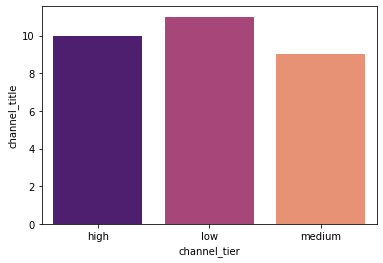

In [70]:
sns.barplot(x=ch_df.groupby('channel_tier').count()['channel_title'].index,y=ch_df.groupby('channel_tier').count()['channel_title'],palette=use_palette)

Created channel title list (separate tier)

Now we can work with different tiers separately

Text(0.5, 1.0, 'No. of subscribers - Low tier')

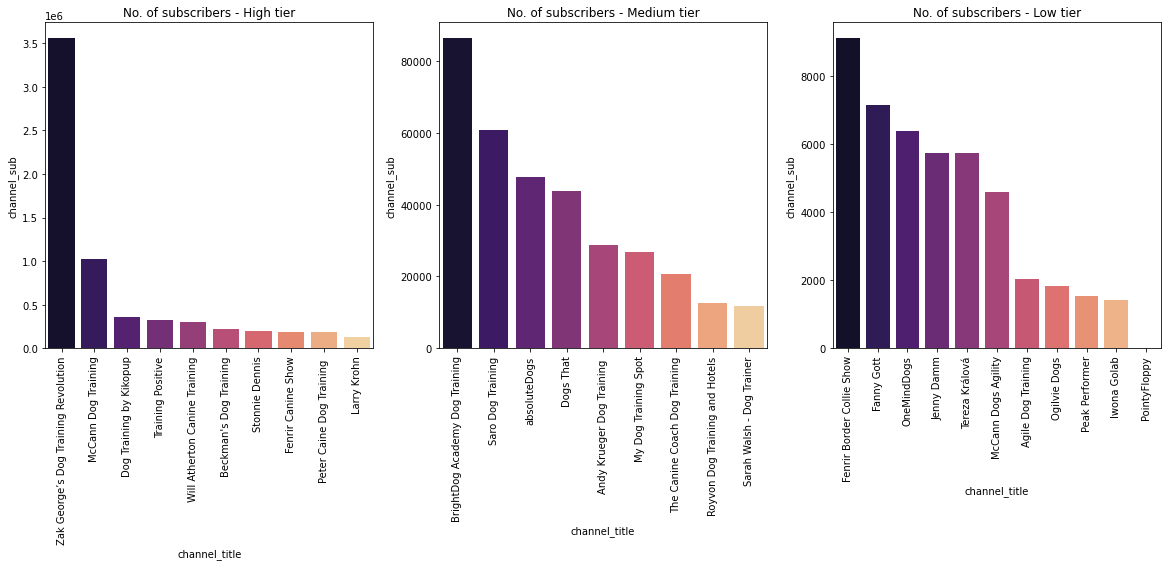

In [40]:
fig, axes = plt.subplots(1, 3,figsize=(20,6))

sns.barplot(ax=axes[0], x='channel_title', y='channel_sub',data=ch_df[ch_df['channel_tier']=='high'].sort_values(by='channel_sub',ascending=False),palette=use_palette)
axes[0].set_xticklabels(ch_df[ch_df['channel_tier']=='high'].sort_values(by='channel_sub',ascending=False)['channel_title'],rotation = 90)
axes[0].set_title('No. of subscribers - High tier')

sns.barplot(ax=axes[1], x='channel_title', y='channel_sub',data=ch_df[ch_df['channel_tier']=='medium'].sort_values(by='channel_sub',ascending=False),palette=use_palette)
axes[1].set_xticklabels(ch_df[ch_df['channel_tier']=='medium'].sort_values(by='channel_sub',ascending=False)['channel_title'],rotation = 90)
axes[1].set_title('No. of subscribers - Medium tier')

sns.barplot(ax=axes[2], x='channel_title', y='channel_sub',data=ch_df[ch_df['channel_tier']=='low'].sort_values(by='channel_sub',ascending=False),palette=use_palette)
axes[2].set_xticklabels(ch_df[ch_df['channel_tier']=='low'].sort_values(by='channel_sub',ascending=False)['channel_title'],rotation = 90)
axes[2].set_title('No. of subscribers - Low tier')

Text(0.5, 1.0, 'No. of videos in low tier channels')

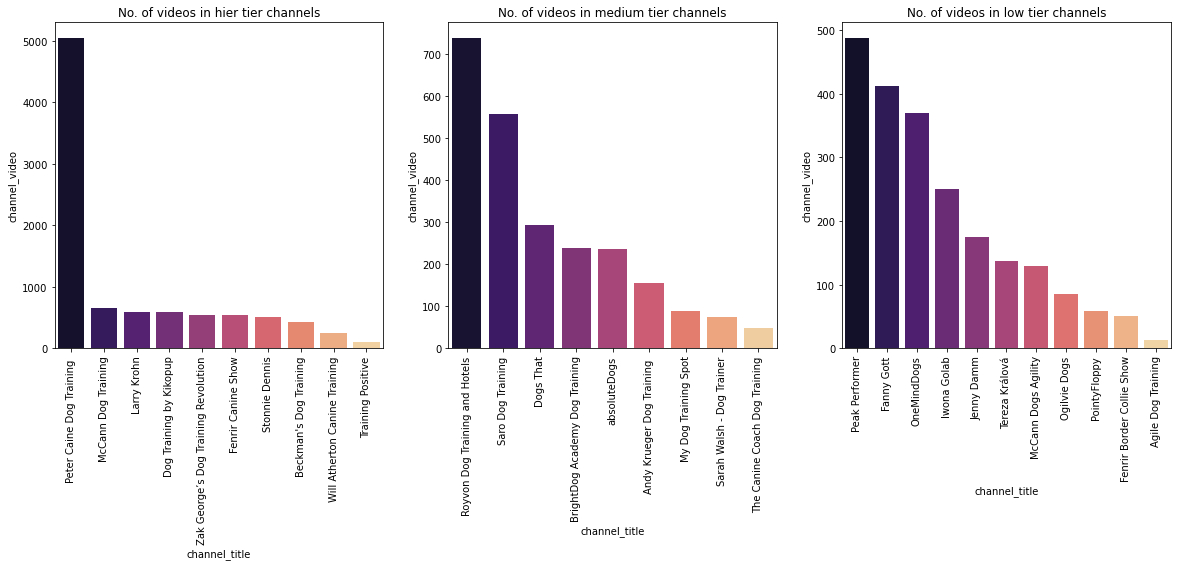

In [44]:
fig, axes = plt.subplots(1, 3,figsize=(20,6))

sns.barplot(ax=axes[0], x='channel_title', y='channel_video',data=ch_df[ch_df['channel_tier']=='high'].sort_values(by='channel_video',ascending=False),palette=use_palette)
axes[0].set_xticklabels(ch_df[ch_df['channel_tier']=='high'].sort_values(by='channel_video',ascending=False)['channel_title'],rotation = 90)
axes[0].set_title('No. of videos in hier tier channels')

sns.barplot(ax=axes[1], x='channel_title', y='channel_video',data=ch_df[ch_df['channel_tier']=='medium'].sort_values(by='channel_video',ascending=False),palette=use_palette)
axes[1].set_xticklabels(ch_df[ch_df['channel_tier']=='medium'].sort_values(by='channel_video',ascending=False)['channel_title'],rotation = 90)
axes[1].set_title('No. of videos in medium tier channels')

sns.barplot(ax=axes[2], x='channel_title', y='channel_video',data=ch_df[ch_df['channel_tier']=='low'].sort_values(by='channel_video',ascending=False),palette=use_palette)
axes[2].set_xticklabels(ch_df[ch_df['channel_tier']=='low'].sort_values(by='channel_video',ascending=False)['channel_title'],rotation = 90)
axes[2].set_title('No. of videos in low tier channels')

We will focus on low channel first

[Text(0.5, 1.0, 'High Tier \n Channel views vs channel subscribers \n')]

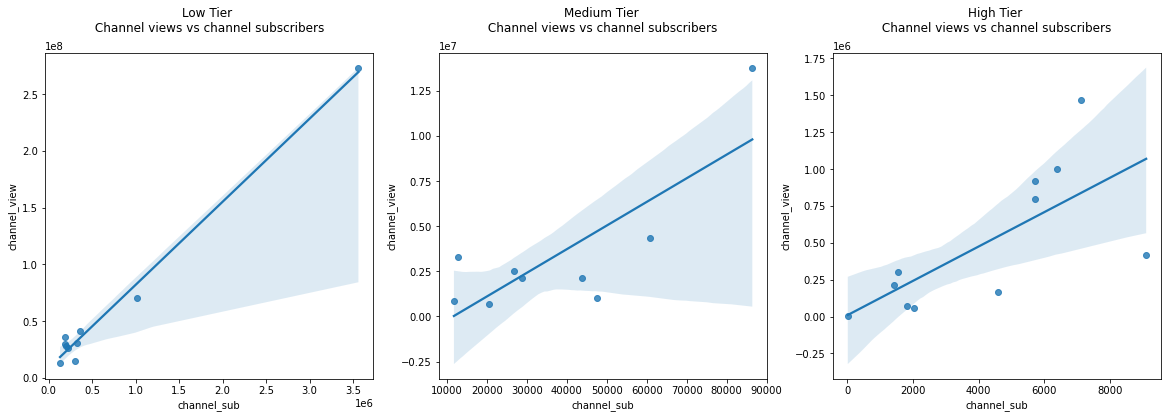

In [52]:
#excluding the top two outliers - we will investigate the channel sub vs channel views
fig, axes = plt.subplots(1, 3,figsize=(20,6))

sns.regplot(ax=axes[0], x='channel_sub', y='channel_view', data = ch_df[ch_df['channel_tier']=='high'])
axes[0].set(title='Low Tier \n Channel views vs channel subscribers \n')

sns.regplot(ax=axes[1], x='channel_sub', y='channel_view', data = ch_df[ch_df['channel_tier']=='medium'])
axes[1].set(title='Medium Tier \n Channel views vs channel subscribers \n')

sns.regplot(ax=axes[2], x='channel_sub', y='channel_view', data = ch_df[ch_df['channel_tier']=='low'])
axes[2].set(title='High Tier \n Channel views vs channel subscribers \n')

[Text(0.5, 1.0, 'Low Tier \n Channel published year \n')]

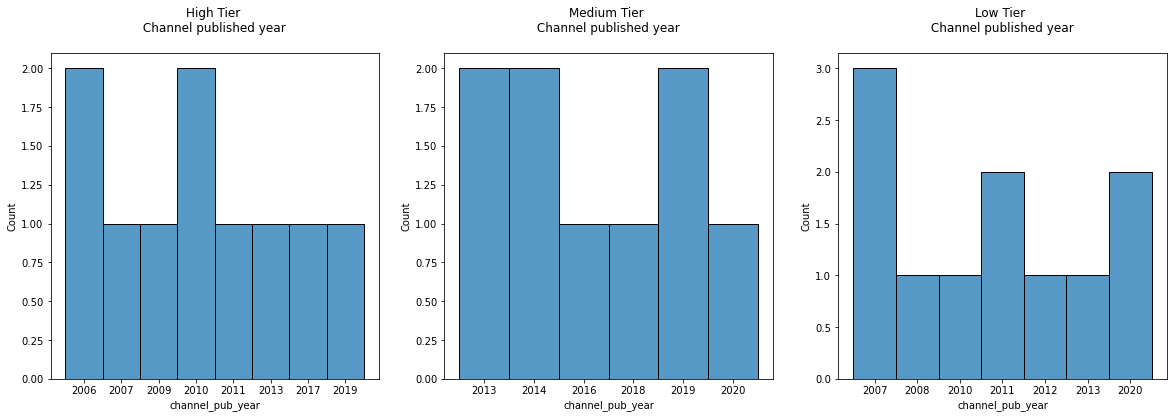

In [218]:
#excluding the top two outliers - we will investigate the channel sub vs channel views
fig, axes = plt.subplots(1, 3,figsize=(20,6))

sns.histplot(ax=axes[0], x='channel_pub_year', data = ch_df[ch_df['channel_tier']=='high'].sort_values(by='channel_pub_year'),bins=10)
axes[0].set(title='High Tier \n Channel published year \n')

sns.histplot(ax=axes[1], x='channel_pub_year', data = ch_df[ch_df['channel_tier']=='medium'].sort_values(by='channel_pub_year'),bins=10)
axes[1].set(title='Medium Tier \n Channel published year \n')

sns.histplot(ax=axes[2], x='channel_pub_year', data = ch_df[ch_df['channel_tier']=='low'].sort_values(by='channel_pub_year'),bins=10)
axes[2].set(title='Low Tier \n Channel published year \n')

## EDA : Videos

In [222]:
video_df.head(5)

video_id         channelTitle  \
0  6ZV2Qk7zwME  McCann Dogs Agility   
1  HV1S-hIkyh0  McCann Dogs Agility   
2  sHPVpX-p-ck  McCann Dogs Agility   
3  XVCTAUQkdDY  McCann Dogs Agility   
4  ExdMGCn7XOg  McCann Dogs Agility   

                                               title  \
0  Kayl McCann & Bee-Line - UKI Ontario Fall Cup ...   
1  Ep7: Part 1: A Conversation with Jaakko Suoknu...   
2  Run or Stop? That is the question…..  Here Is ...   
3  Ep6: Training & Competing with Multiple Dogs -...   
4  Agility Coursework - May 2021/ Coach Kayl McCa...   

                                         description  \
0  I’m a little late with posting my Fall Cup rec...   
1  We are so pumped for this 2-part conversation ...   
2  Running or Stop Contacts…..well, I’d say, if y...   
3  If you play Agility, you know it's an amazingl...   
4  This weeks training sessions with Bee-Line 🐝\n...   

                                                tags  \
0  ['Agility', 'Dog Agility', 'Bee-Line', 'Kayl M...   
1  ['kayl', 'mccann', 'dog', 'agility', 'dog agil...   
2                                                 []   
3  ['kayl', 'mccann', 'dog', 'agility', 'dog agil...   
4                                                 []   

                publishedAt   duration definition  caption  viewCount  ...  \
0 2021-10-30 22:19:00+00:00    PT5M14S         hd    False       1648  ...   
1 2021-06-26 04:00:23+00:00  PT1H3M21S         hd    False        986  ...   
2 2021-06-10 13:07:33+00:00    PT1M15S         hd    False        874  ...   
3 2021-06-04 12:00:26+00:00    PT36M1S         hd    False        384  ...   
4 2021-05-23 05:02:56+00:00    PT1M49S         hd    False        802  ...   

   publishedMonth  duration_sec duration_min  \
0              10         314.0            5   
1              06        3801.0           63   
2              06          75.0            1   
3              06        2161.0           36   
4              05         109.0            2   

                                           tags_list  tags_count  likeRatio  \
0  [Agility, Dog Agility, Bee-Line, Kayl McCann, ...           6  20.024272   
1  [kayl, mccann, dog, agility, dog agility train...          20  18.255578   
2                                                 []           1  18.306636   
3  [kayl, mccann, dog, agility, dog agility train...          15  41.666667   
4                                                 []           1  29.925187   

  commentRatio  title_length  channel_tier  publishedYear  
0     1.820388            61           low           2021  
1     0.000000            71           low           2021  
2     2.288330            55           low           2021  
3     7.812500            66           low           2021  
4     1.246883            78           low           2021  

[5 rows x 23 columns]

<AxesSubplot:xlabel='channel_tier', ylabel='video_id'>

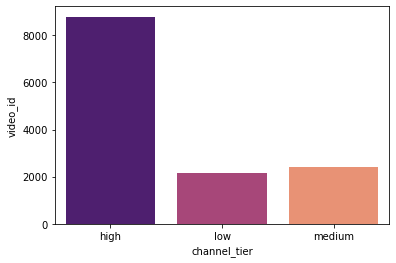

In [68]:
sns.barplot(x=video_df.groupby('channel_tier').count()['video_id'].index,y=video_df.groupby('channel_tier').count()['video_id'],palette=use_palette)

#### Separate video data into different tiers

[Text(0.5, 1.0, 'Low Tier Feature Correlation')]

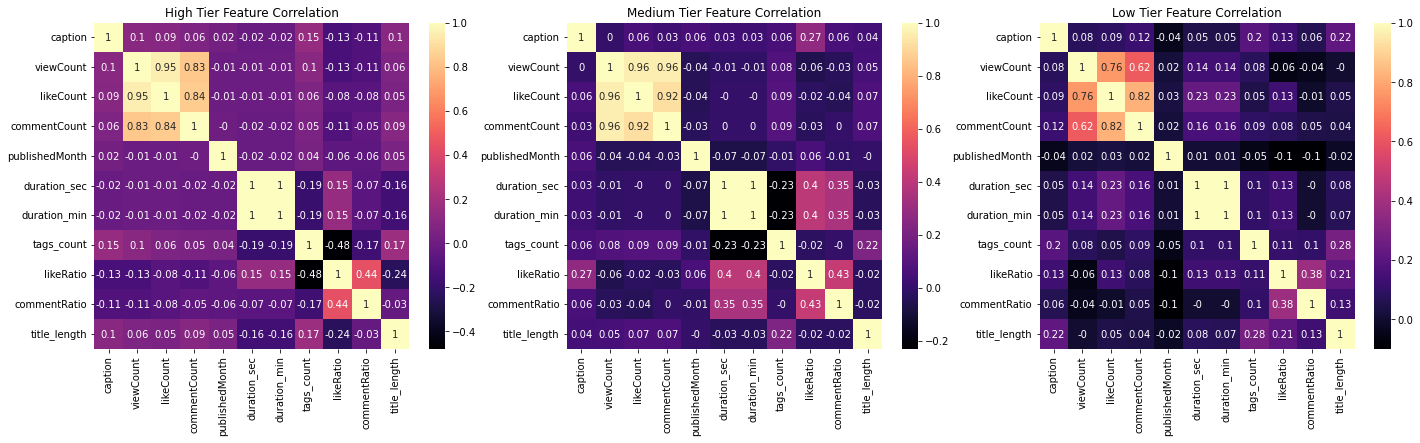

In [54]:
fig, axes = plt.subplots(1, 3,figsize=(24,6))

sns.heatmap(ax=axes[0], data=video_df[video_df['channel_tier']=='high'].corr().round(2),annot=True,cmap=use_palette).set(title='High Tier Feature Correlation')
sns.heatmap(ax=axes[1], data=video_df[video_df['channel_tier']=='medium'].corr().round(2),annot=True,cmap=use_palette).set(title='Medium Tier Feature Correlation')
sns.heatmap(ax=axes[2], data=video_df[video_df['channel_tier']=='low'].corr().round(2),annot=True,cmap=use_palette).set(title='Low Tier Feature Correlation')

Check average tags per video per channel and by tier

In [55]:
video_tag_df = pd.DataFrame(video_df.groupby(by='channelTitle').mean()['tags_count'])
video_tag_df = video_tag_df.merge(ch_df[['channel_title','channel_tier']],left_on='channelTitle',right_on='channel_title',how='left')

Text(0.5, 1.0, 'No. of tags per video in low tier channels')

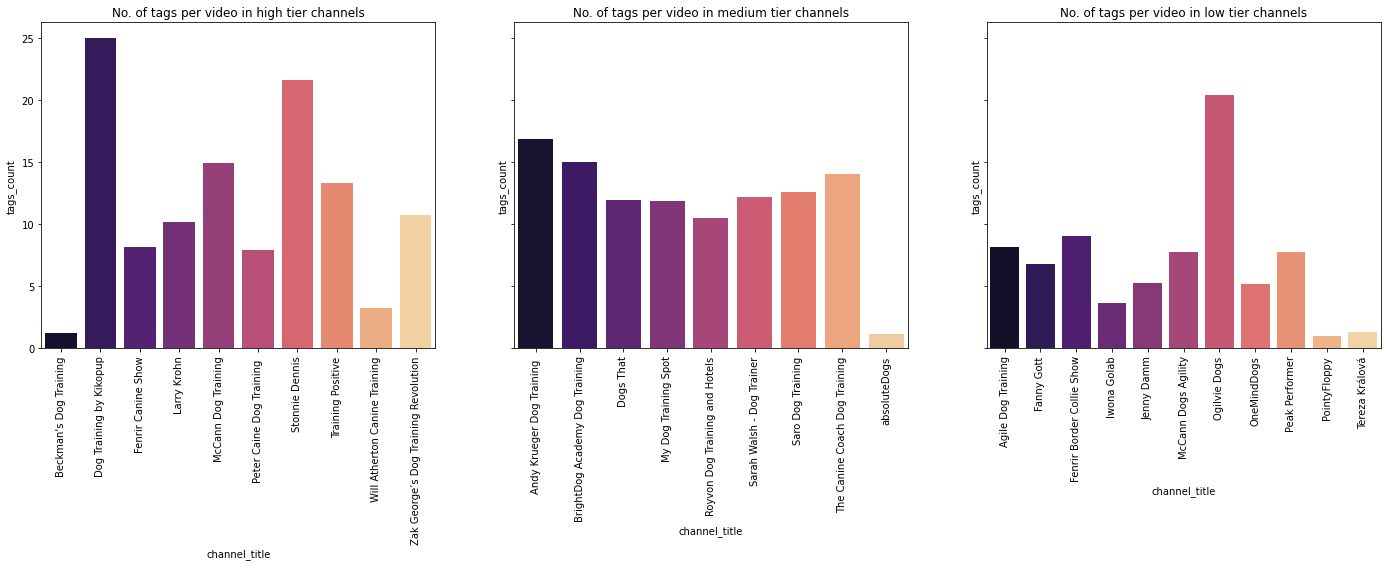

In [57]:
fig, axes = plt.subplots(1, 3,figsize=(24,6),sharey=True)

sns.barplot(ax=axes[0], x='channel_title', y='tags_count',data=video_tag_df[video_tag_df['channel_tier']=='high'],palette=use_palette)
axes[0].set_xticklabels(video_tag_df[video_tag_df['channel_tier']=='high']['channel_title'],rotation = 90)
axes[0].set_title('No. of tags per video in high tier channels')

sns.barplot(ax=axes[1], x='channel_title', y='tags_count',data=video_tag_df[video_tag_df['channel_tier']=='medium'],palette=use_palette)
axes[1].set_xticklabels(video_tag_df[video_tag_df['channel_tier']=='medium']['channel_title'],rotation = 90)
axes[1].set_title('No. of tags per video in medium tier channels')

sns.barplot(ax=axes[2], x='channel_title', y='tags_count',data=video_tag_df[video_tag_df['channel_tier']=='low'],palette=use_palette)
axes[2].set_xticklabels(video_tag_df[video_tag_df['channel_tier']=='low']['channel_title'],rotation = 90)
axes[2].set_title('No. of tags per video in low tier channels')

#### Investigating relationships between tags and view counts

Text(0.5, 1.0, 'tags_count vs view - Low tier')

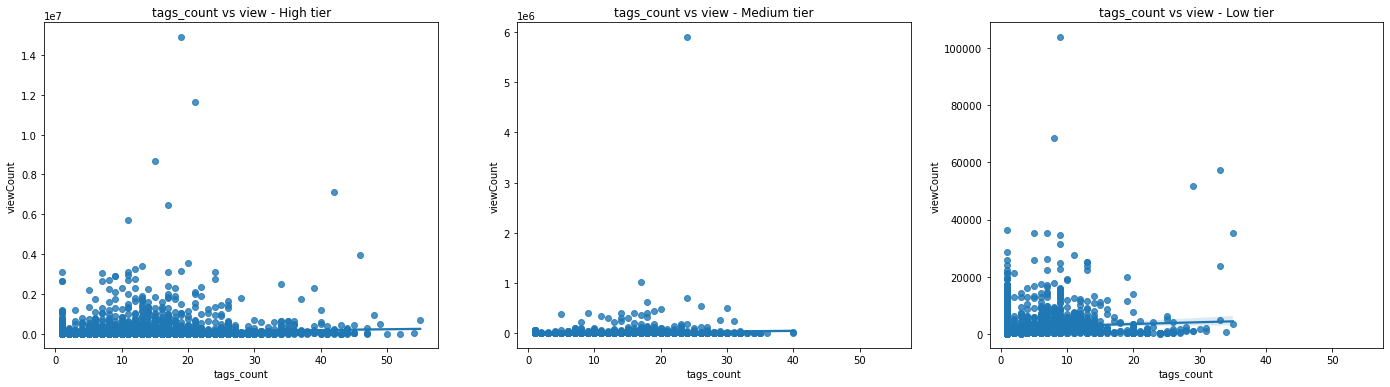

In [60]:
fig, axes = plt.subplots(1, 3,figsize=(24,6),sharex=True)

sns.regplot(ax=axes[0],x='tags_count', y='viewCount', data=video_df[video_df['channel_tier']=='high'])
axes[0].set_title('tags_count vs view - High tier')

sns.regplot(ax=axes[1],x='tags_count', y='viewCount', data=video_df[video_df['channel_tier']=='medium'])
axes[1].set_title('tags_count vs view - Medium tier')

sns.regplot(ax=axes[2],x='tags_count', y='viewCount', data=video_df[video_df['channel_tier']=='low'])
axes[2].set_title('tags_count vs view - Low tier')

#### Investigate relationship between title length and view counts

Text(0.5, 1.0, 'title_length vs view - Low tier')

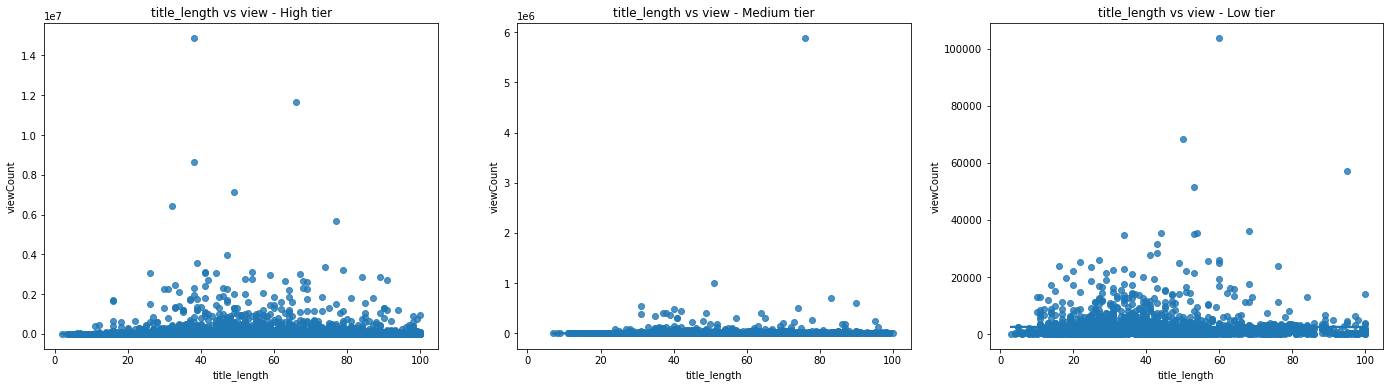

In [63]:
fig, axes = plt.subplots(1, 3,figsize=(24,6),sharex=True)

sns.regplot(ax=axes[0],x='title_length', y='viewCount', data=video_df[video_df['channel_tier']=='high'])
axes[0].set_title('title_length vs view - High tier')

sns.regplot(ax=axes[1],x='title_length', y='viewCount', data=video_df[video_df['channel_tier']=='medium'])
axes[1].set_title('title_length vs view - Medium tier')

sns.regplot(ax=axes[2],x='title_length', y='viewCount', data=video_df[video_df['channel_tier']=='low'])
axes[2].set_title('title_length vs view - Low tier')

#### comment count vs view count

<Figure size 864x432 with 0 Axes>

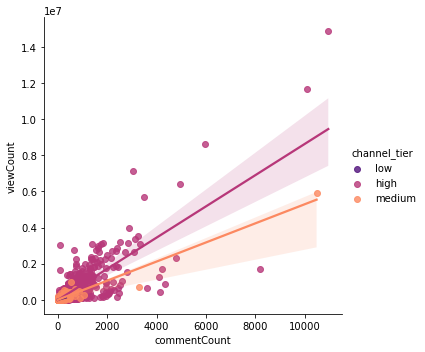

In [84]:
plt.figure(figsize=(12,6))
sns.lmplot(x='commentCount',y='viewCount',data=video_df,hue='channel_tier',palette=use_palette)

<Figure size 864x432 with 0 Axes>

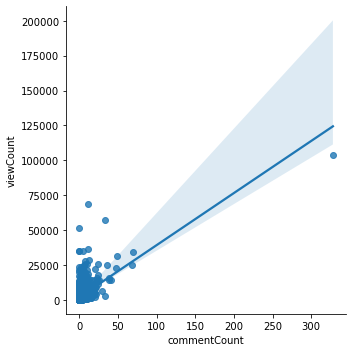

In [85]:
plt.figure(figsize=(12,6))
sns.lmplot(x='commentCount',y='viewCount',data=video_df[video_df['channel_tier']=='low'])

<Figure size 864x432 with 0 Axes>

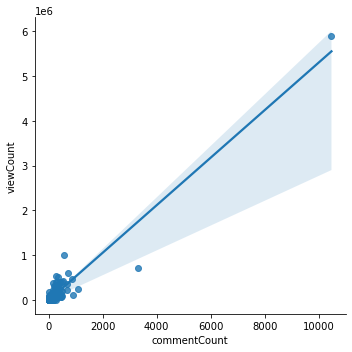

In [86]:
plt.figure(figsize=(12,6))
sns.lmplot(x='commentCount',y='viewCount',data=video_df[video_df['channel_tier']=='medium'])

<Figure size 864x432 with 0 Axes>

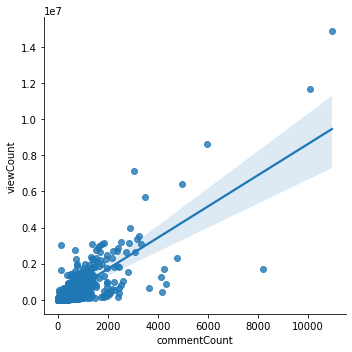

In [87]:
plt.figure(figsize=(12,6))
sns.lmplot(x='commentCount',y='viewCount',data=video_df[video_df['channel_tier']=='high'])

observation: seems like there is a trend between view and comment - possibly due to youtube algorithm

<Figure size 864x432 with 0 Axes>

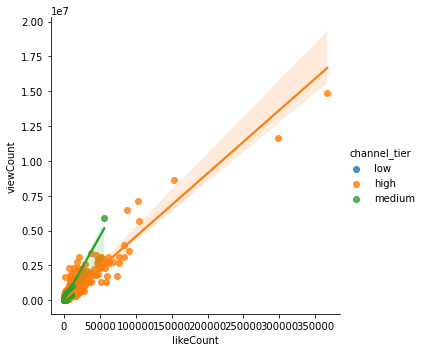

In [88]:
plt.figure(figsize=(12,6))
sns.lmplot(x='likeCount',y='viewCount',data=video_df,hue='channel_tier')

<Figure size 864x432 with 0 Axes>

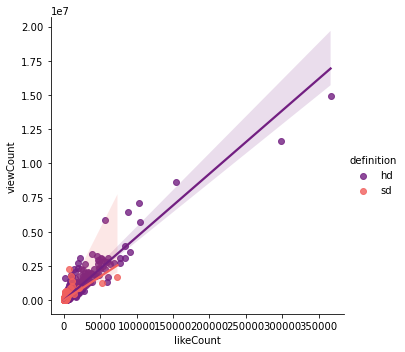

In [89]:
plt.figure(figsize=(12,6))
sns.lmplot(x='likeCount',y='viewCount',data=video_df,hue='definition',palette=use_palette)

#### Video duration correlation

Text(0.5, 1.0, 'duration vs view - Low tier')

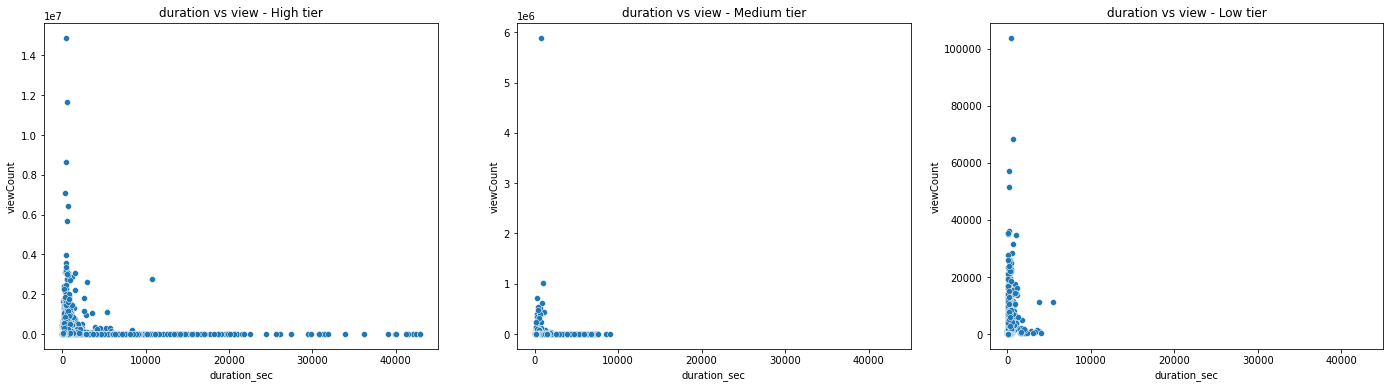

In [90]:
fig, axes = plt.subplots(1, 3,figsize=(24,6),sharex=True)

sns.scatterplot(ax=axes[0],x='duration_sec', y='viewCount', data=video_df[video_df['channel_tier']=='high'],palette=use_palette)
axes[0].set_title('duration vs view - High tier')

sns.scatterplot(ax=axes[1],x='duration_sec', y='viewCount', data=video_df[video_df['channel_tier']=='medium'],palette=use_palette)
axes[1].set_title('duration vs view - Medium tier')

sns.scatterplot(ax=axes[2],x='duration_sec', y='viewCount', data=video_df[video_df['channel_tier']=='low'],palette=use_palette)
axes[2].set_title('duration vs view - Low tier')

Text(0.5, 1.0, 'duration vs view - Low tier')

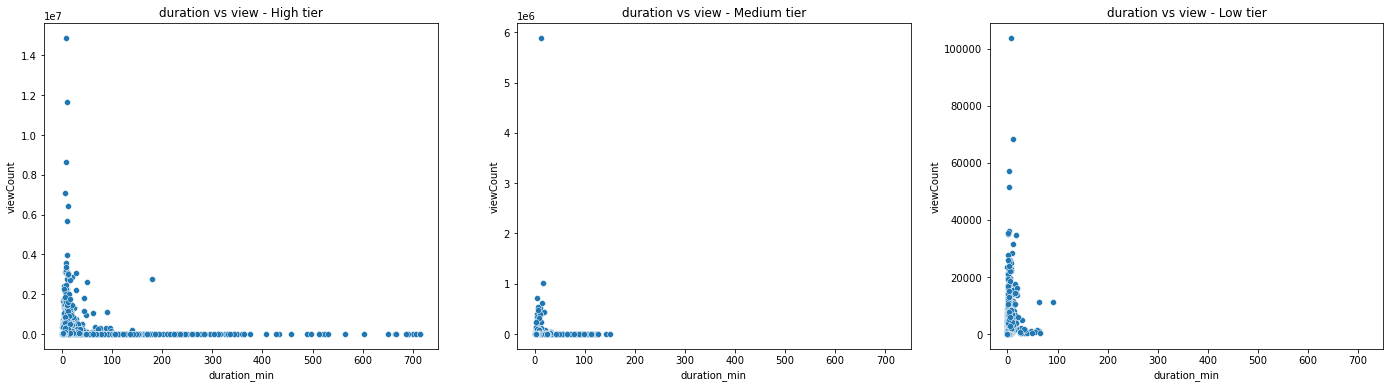

In [91]:
fig, axes = plt.subplots(1, 3,figsize=(24,6),sharex=True)

sns.scatterplot(ax=axes[0],x='duration_min', y='viewCount', data=video_df[video_df['channel_tier']=='high'],palette=use_palette)
axes[0].set_title('duration vs view - High tier')

sns.scatterplot(ax=axes[1],x='duration_min', y='viewCount', data=video_df[video_df['channel_tier']=='medium'],palette=use_palette)
axes[1].set_title('duration vs view - Medium tier')

sns.scatterplot(ax=axes[2],x='duration_min', y='viewCount', data=video_df[video_df['channel_tier']=='low'],palette=use_palette)
axes[2].set_title('duration vs view - Low tier')

Text(0.5, 1.0, 'Video duration distribution - Low tier')

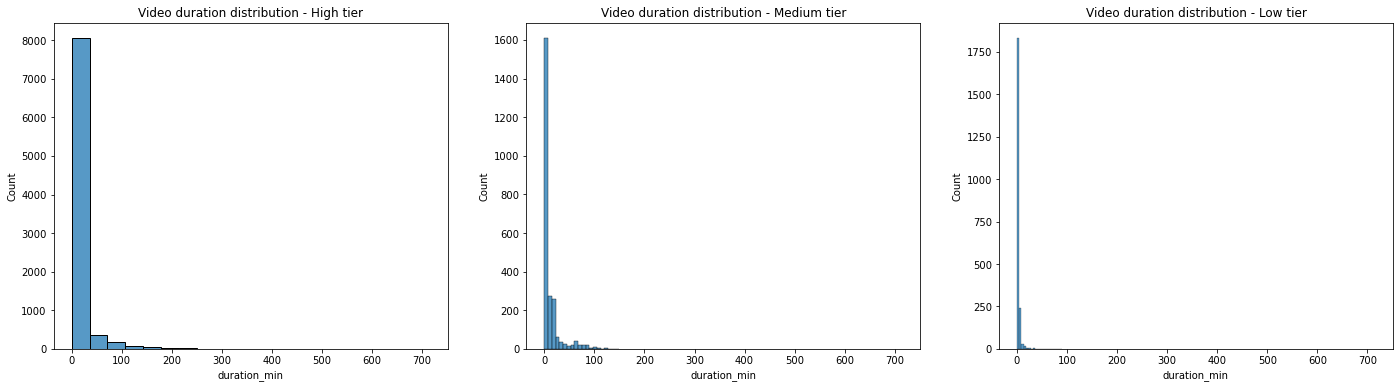

In [92]:
fig, axes = plt.subplots(1, 3,figsize=(24,6),sharex=True)

sns.histplot(ax=axes[0],x='duration_min', bins=20, data=video_df[video_df['channel_tier']=='high'], palette=use_palette)
axes[0].set_title('Video duration distribution - High tier')

sns.histplot(ax=axes[1],x='duration_min', bins=20, data=video_df[video_df['channel_tier']=='medium'], palette=use_palette)
axes[1].set_title('Video duration distribution - Medium tier')

sns.histplot(ax=axes[2],x='duration_min', bins=20, data=video_df[video_df['channel_tier']=='low'], palette=use_palette)
axes[2].set_title('Video duration distribution - Low tier')

#### Exploration of days of the week

Text(0.5, 1.0, 'Views for each posted day by low tier channel')

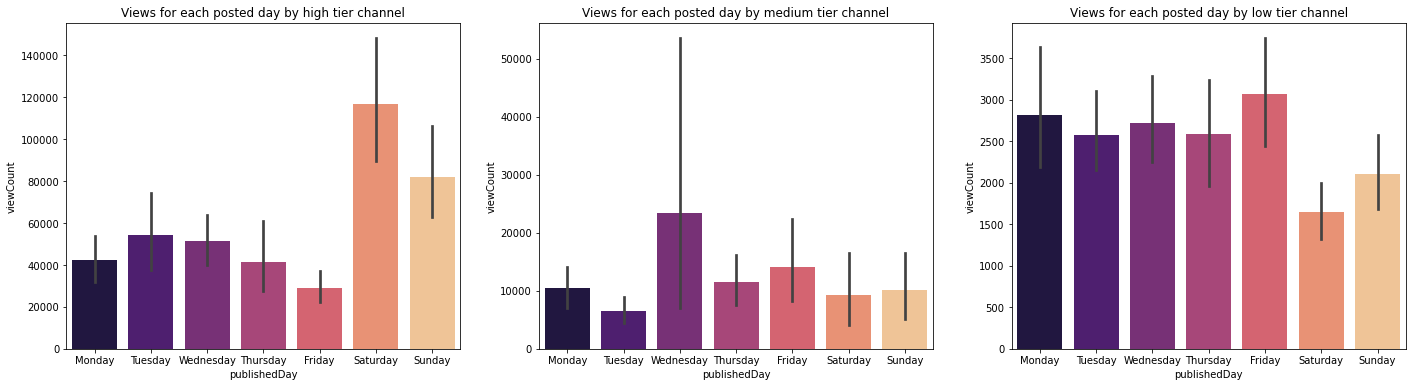

In [93]:
fig, axes = plt.subplots(1, 3,figsize=(24,6))

sns.barplot(ax=axes[0], x='publishedDay', y='viewCount', data=video_df[video_df['channel_tier']=='high'], order=day_order,palette=use_palette)
axes[0].set_title('Views for each posted day by high tier channel')

sns.barplot(ax=axes[1], x='publishedDay', y='viewCount', data=video_df[video_df['channel_tier']=='medium'], order=day_order,palette=use_palette)
axes[1].set_title('Views for each posted day by medium tier channel')

sns.barplot(ax=axes[2], x='publishedDay', y='viewCount', data=video_df[video_df['channel_tier']=='low'], order=day_order,palette=use_palette)
axes[2].set_title('Views for each posted day by low tier channel')

Text(0.5, 1.0, 'Views for each posted month by low tier channel')

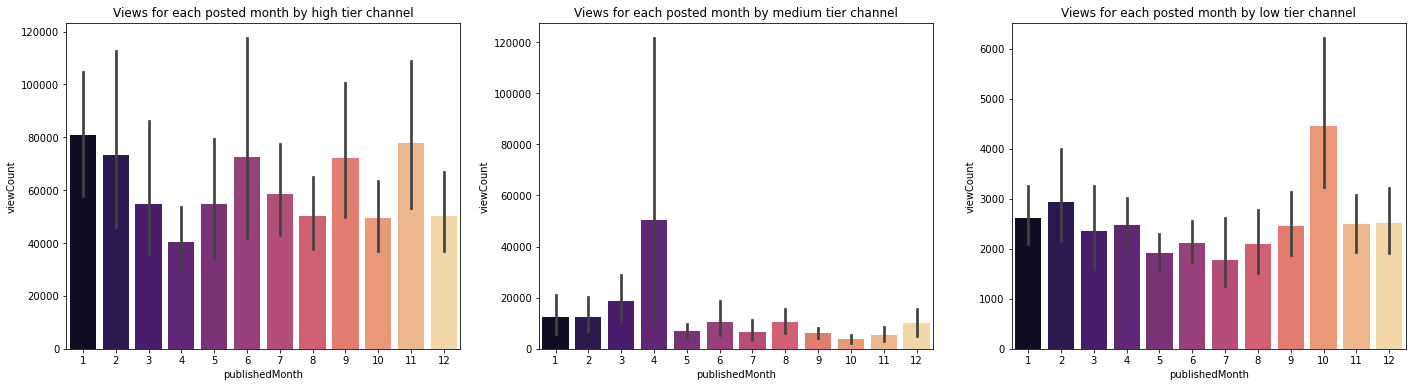

In [94]:
fig, axes = plt.subplots(1, 3,figsize=(24,6))

sns.barplot(ax=axes[0], x='publishedMonth', y='viewCount', data=video_df[video_df['channel_tier']=='high'], palette=use_palette)
axes[0].set_title('Views for each posted month by high tier channel')

sns.barplot(ax=axes[1], x='publishedMonth', y='viewCount', data=video_df[video_df['channel_tier']=='medium'], palette=use_palette)
axes[1].set_title('Views for each posted month by medium tier channel')

sns.barplot(ax=axes[2], x='publishedMonth', y='viewCount', data=video_df[video_df['channel_tier']=='low'], palette=use_palette)
axes[2].set_title('Views for each posted month by low tier channel')

Text(0.5, 1.0, 'Average videos published each month - Low tier')

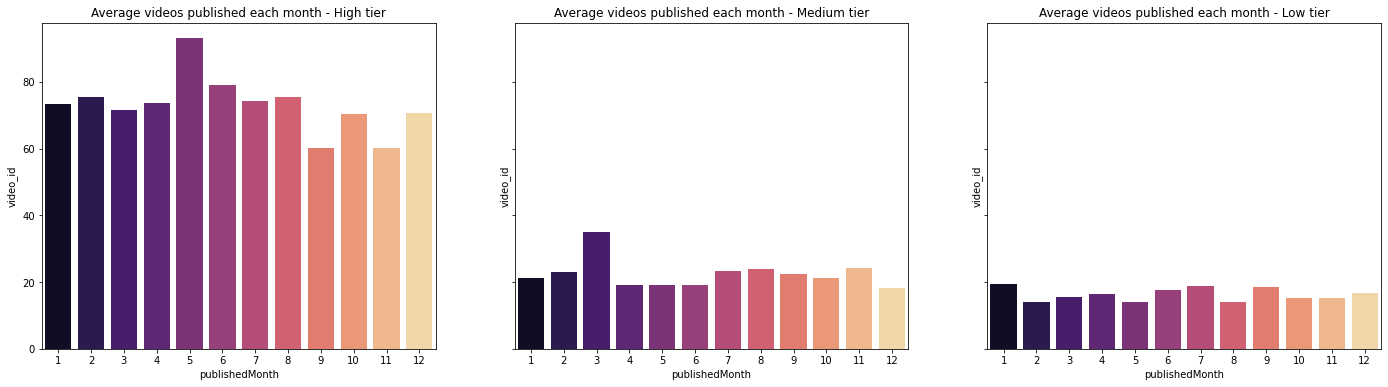

In [95]:
#check average posted videos per month
fig, axes = plt.subplots(1, 3,figsize=(24,6),sharey=True)

high_posted_video = pd.DataFrame(video_df[video_df['channel_tier']=='high'].groupby('publishedMonth').count()['video_id']/ch_df[ch_df['channel_tier']=='high']['channel_title'].count())
medium_posted_video = pd.DataFrame(video_df[video_df['channel_tier']=='medium'].groupby('publishedMonth').count()['video_id']/ch_df[ch_df['channel_tier']=='medium']['channel_title'].count())
low_posted_video = pd.DataFrame(video_df[video_df['channel_tier']=='low'].groupby('publishedMonth').count()['video_id']/ch_df[ch_df['channel_tier']=='low']['channel_title'].count())

sns.barplot(ax=axes[0],x=high_posted_video.index,y='video_id',data=high_posted_video, palette=use_palette)
axes[0].set_title('Average videos published each month - High tier')

sns.barplot(ax=axes[1],x=medium_posted_video.index,y='video_id',data=medium_posted_video, palette=use_palette)
axes[1].set_title('Average videos published each month - Medium tier')

sns.barplot(ax=axes[2],x=low_posted_video.index,y='video_id',data=low_posted_video, palette=use_palette)
axes[2].set_title('Average videos published each month - Low tier')

Verify the consistency of posted month

#### Go back all data

In [ ]:
#can I create a video title suggestion model ?

In [96]:
type(list(video_df[video_df['channel_tier']=='low']['title'][0]))

list

In [97]:
stop_words = set(stopwords.words('english'))

low_title = pd.DataFrame()
medium_title = pd.DataFrame()
high_title = pd.DataFrame()

low_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='low']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
medium_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='medium']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
high_title['title_no_stopwords'] = video_df[video_df['channel_tier']=='high']['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])

In [98]:
low_title_words = [a for b in low_title['title_no_stopwords'].tolist() for a in b] #I don't get this
medium_title_words = [a for b in medium_title['title_no_stopwords'].tolist() for a in b] #I don't get this
high_title_words = [a for b in high_title['title_no_stopwords'].tolist() for a in b] #I don't get this

In [99]:
low_title_words_str = ' '.join(low_title_words)
medium_title_words_str = ' '.join(medium_title_words)
high_title_words_str = ' '.join(high_title_words)

In [279]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis('off');
    
low_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(low_title_words_str)

medium_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(medium_title_words_str)

high_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(high_title_words_str)

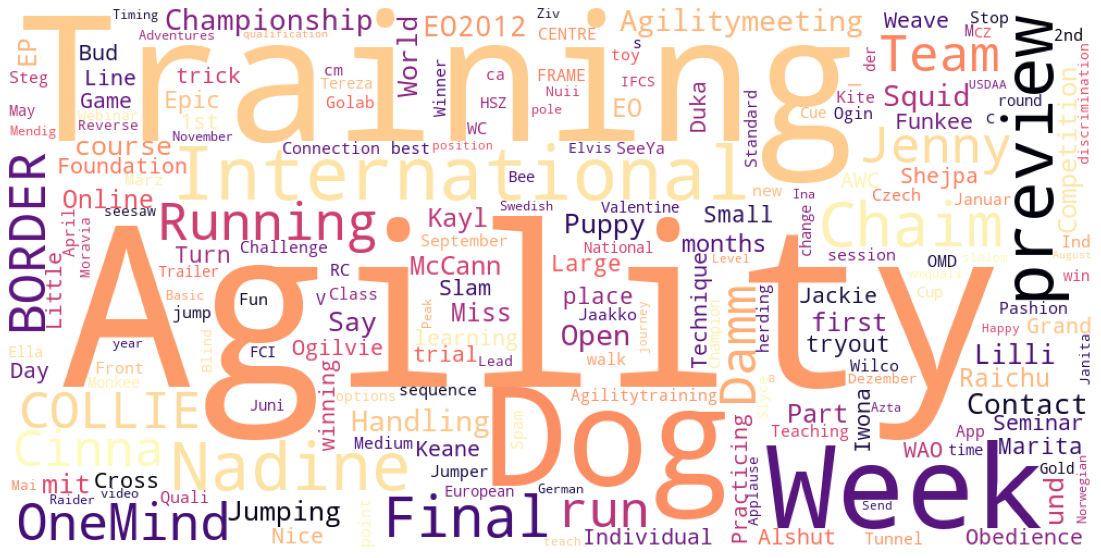

In [280]:
plot_cloud(low_wordcloud)

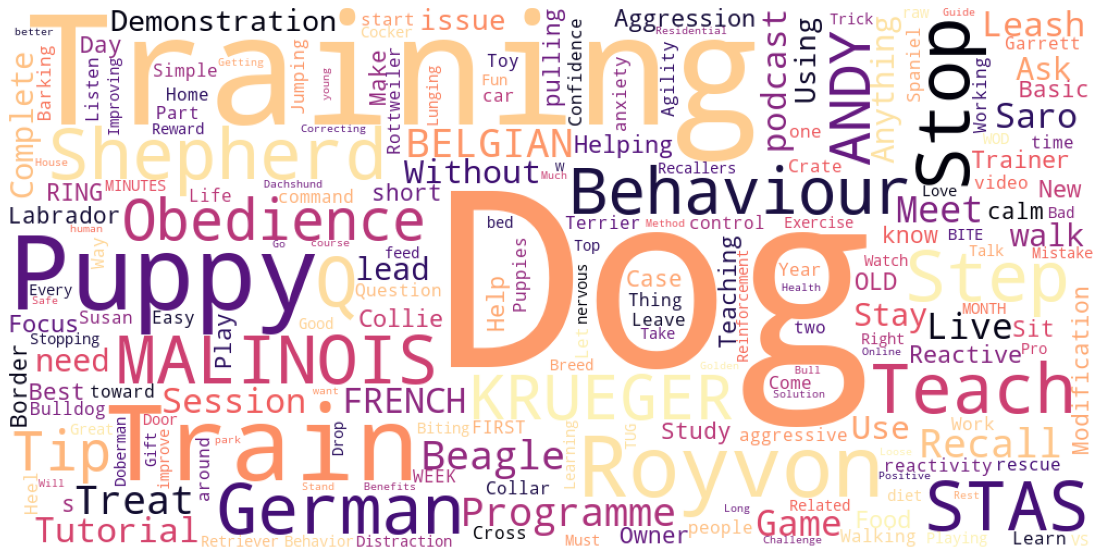

In [281]:
plot_cloud(medium_wordcloud)

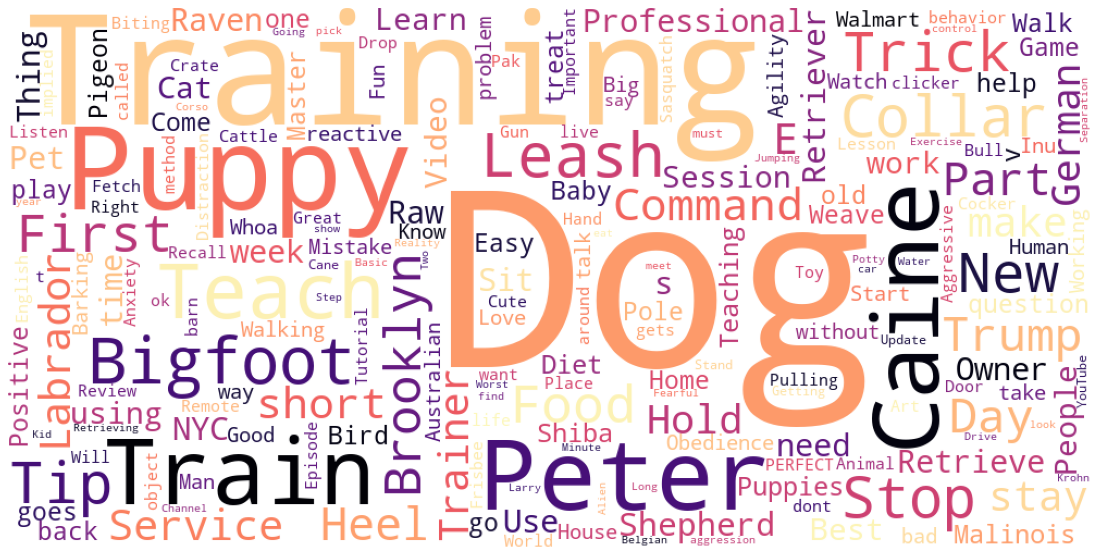

In [282]:
plot_cloud(high_wordcloud)

# EDA : Comments

In [104]:
cm_df = pd.read_csv('comments_df.csv')

In [105]:
cm_df = cm_df.merge(video_df[['video_id','channel_tier']],on='video_id',how='left')

In [106]:
cm_df[cm_df['comments'] != '[]']

video_id                                           comments  \
0     6ZV2Qk7zwME  ['You are both so fast 💨', "Do you have any ti...   
2     sHPVpX-p-ck                          ['Amazing', 'Incredible']   
3     XVCTAUQkdDY  ['I one hundred percent agree with you about h...   
4     ExdMGCn7XOg                                       ['Amazing!']   
5     MTK9BDZTqAY  ['Great Info. Thank you', 'I have a goldendood...   
...           ...                                                ...   
8958  NHSojk4hsr0  ['would be great to see a before video of the ...   
8960  LcY46cjBkAs  ["We have a street dog, Rocky. He's very sweet...   
8962  3WLeyrSMRDg  ['their stunning dogs thanks for sharing this x']   
8968  _mBkn6plhb0  ["You left out :-\n1. They are the worst for p...   
8981  8Nxgtc5vYTo  ['am very interested in applying for a dog, fo...   

     channel_tier  
0             low  
2             low  
3             low  
4             low  
5             low  
...           ...  
8958       medium  
8960       medium  
8962       medium  
8968       medium  
8981       medium  

[7479 rows x 3 columns]

In [107]:
low_comment = pd.DataFrame() 
medium_comment = pd.DataFrame()
high_comment = pd.DataFrame()

low_comment['comment_no_stopwords'] = cm_df[cm_df['channel_tier']=='low']['comments'].apply(lambda x : [item for item in x.split() if item not in stop_words])
medium_comment['comment_no_stopwords'] = cm_df[cm_df['channel_tier']=='medium']['comments'].apply(lambda x : [item for item in x.split() if item not in stop_words])
high_comment['comment_no_stopwords'] = cm_df[cm_df['channel_tier']=='high']['comments'].apply(lambda x : [item for item in x.split() if item not in stop_words])

In [108]:
low_comment_words = [a for b in low_comment['comment_no_stopwords'].tolist() for a in b] #I don't get this
medium_comment_words = [a for b in medium_comment['comment_no_stopwords'].tolist() for a in b] #I don't get this
high_comment_words = [a for b in high_comment['comment_no_stopwords'].tolist() for a in b] #I don't get this

In [109]:
low_comment_words_str = ' '.join(low_comment_words)
medium_comment_words_str = ' '.join(medium_comment_words)
high_comment_words_str = ' '.join(high_comment_words)

In [271]:
low_cm_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(low_comment_words_str)

medium_cm_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(medium_comment_words_str)

high_cm_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(high_comment_words_str)

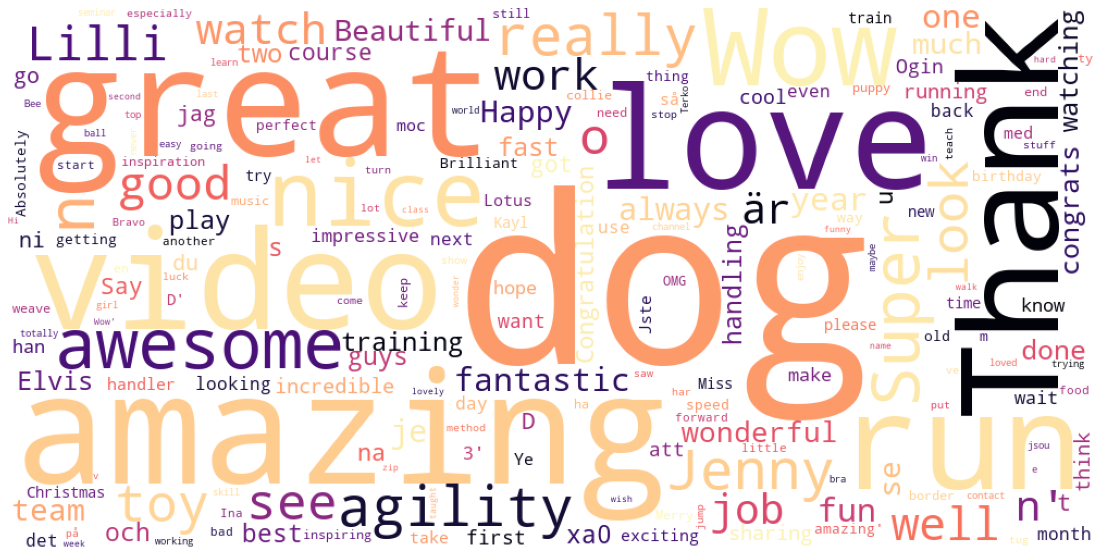

In [272]:
plot_cloud(low_cm_wordcloud)

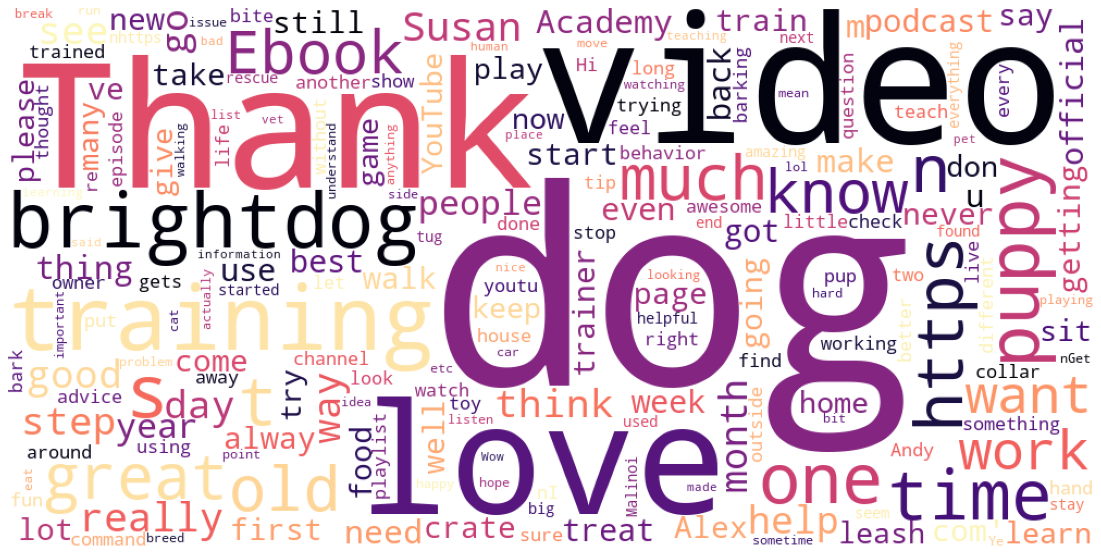

In [273]:
plot_cloud(medium_cm_wordcloud)

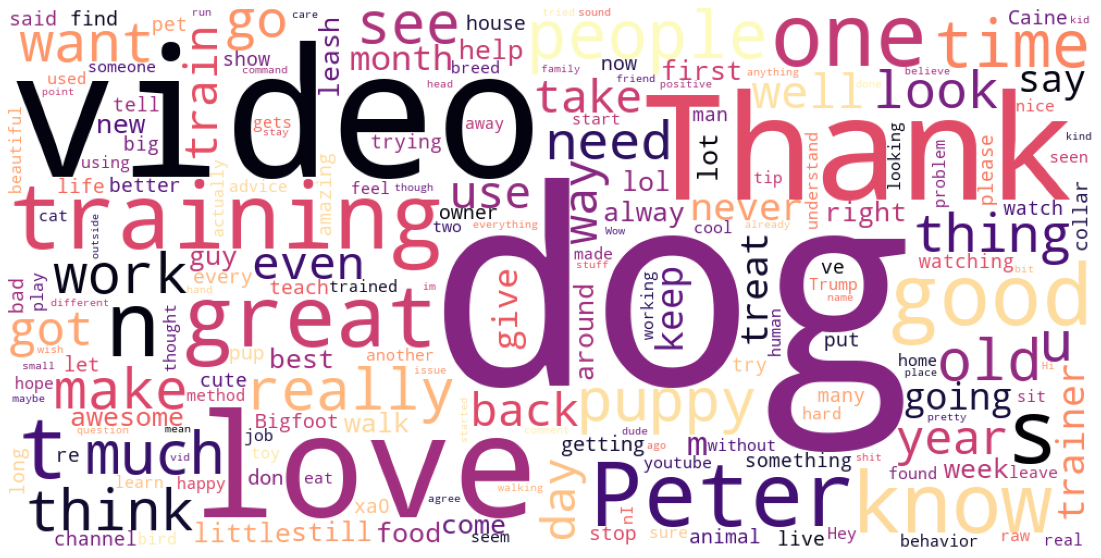

In [274]:
plot_cloud(high_cm_wordcloud)

### EDA Dig Down : Timeline and progress of selected channel

__Selecting channels to dig down (exclude outliers)__

__High Tier__
- Dog Training by Kikopup
- Will Atherton

__Medium Tier__
- absoluteDogs
- Dogs That

__Low Tier__
- Fenrir Border Collie Show
- Fanny Gott

In [213]:
#High Tier

kikopup = pd.DataFrame(video_df[video_df['channelTitle'] == "Dog Training by Kikopup"])
atherton = pd.DataFrame(video_df[video_df['channelTitle'] == "Will Atherton Canine Training"])
mccan = pd.DataFrame(video_df[video_df['channelTitle'] == "McCann Dog Training"])

selected_high = pd.concat([kikopup,atherton,mccan],ignore_index=True)
selected_high_df = pd.DataFrame(selected_high.groupby(['channelTitle','publishedYear']).count()['video_id'])


#Medium Tier
abs_dogs = pd.DataFrame(video_df[video_df['channelTitle'] == "absoluteDogs"])
dogs_that = pd.DataFrame(video_df[video_df['channelTitle'] == "Dogs That"])
saro = pd.DataFrame(video_df[video_df['channelTitle'] == "Saro Dog Training"])

selected_medium = pd.concat([abs_dogs,dogs_that,saro],ignore_index=True)
selected_medium_df = pd.DataFrame(selected_medium.groupby(['channelTitle','publishedYear']).count()['video_id'])

#Low Tier
fenrir_bc = pd.DataFrame(video_df[video_df['channelTitle'] == "Fenrir Border Collie Show"])
fanny_gott = pd.DataFrame(video_df[video_df['channelTitle'] == "Fanny Gott"])
omd = pd.DataFrame(video_df[video_df['channelTitle'] == "OneMindDogs"])

selected_low = pd.concat([fenrir_bc,fanny_gott,omd],ignore_index=True)
selected_low_df = pd.DataFrame(selected_low.groupby(['channelTitle','publishedYear']).count()['video_id'])


Text(0.5, 1.0, 'Videos published timeline - Low tier')

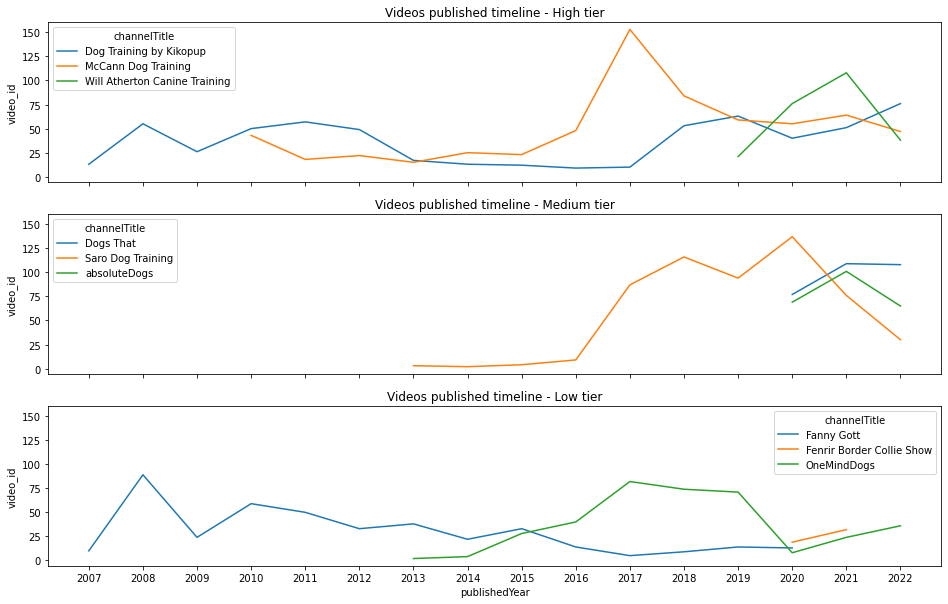

In [217]:
fig, axes = plt.subplots(3, 1,figsize=(16,10),sharey=True,sharex=True)

sns.lineplot(ax=axes[0],x='publishedYear',y='video_id',data=selected_high_df,hue='channelTitle')
axes[0].set_title('Videos published timeline - High tier')

sns.lineplot(ax=axes[1],x='publishedYear',y='video_id',data=selected_medium_df,hue='channelTitle')
axes[1].set_title('Videos published timeline - Medium tier')

sns.lineplot(ax=axes[2],x='publishedYear',y='video_id',data=selected_low_df,hue='channelTitle')
axes[2].set_title('Videos published timeline - Low tier')

Text(0.5, 0, 'Channel Title')

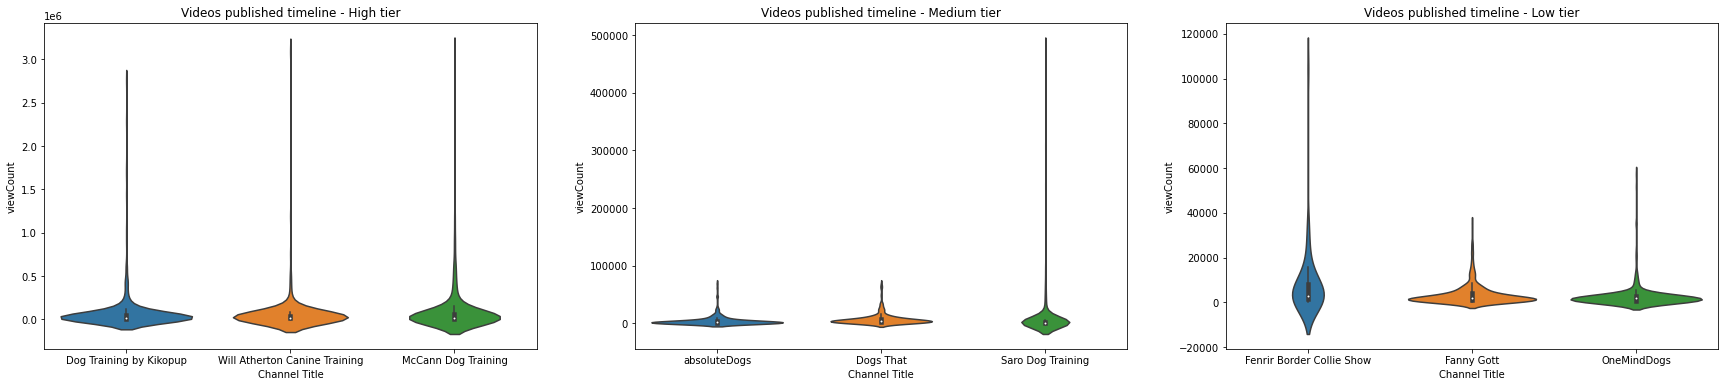

In [251]:
fig, axes = plt.subplots(1, 3,figsize=(30,6))

sns.violinplot(ax=axes[0],x=selected_high['channelTitle'],y=selected_high['viewCount'])
axes[0].set_title('Videos published timeline - High tier')
axes[0].set_xlabel('Channel Title')

sns.violinplot(ax=axes[1],x=selected_medium['channelTitle'],y=selected_medium['viewCount'])
axes[1].set_title('Videos published timeline - Medium tier')
axes[1].set_xlabel('Channel Title')

sns.violinplot(ax=axes[2],x=selected_low['channelTitle'],y=selected_low['viewCount'])
axes[2].set_title('Videos published timeline - Low tier')
axes[2].set_xlabel('Channel Title')

Investigating those viral videos

In [253]:
#High Tier

kikopup_top3 = kikopup.sort_values(by='viewCount').head(3)
atherton_top3 = atherton.sort_values(by='viewCount').head(3)
mccan_top3 = mccan.sort_values(by='viewCount').head(3)

top_high = pd.concat([kikopup_top3,atherton_top3,mccan_top3],ignore_index=True)


#Medium Tier
abs_dogs_top3 = abs_dogs.sort_values(by='viewCount').head(3)
dogs_that_top3 = dogs_that.sort_values(by='viewCount').head(3)
saro_top3 = saro.sort_values(by='viewCount').head(3)

top_medium = pd.concat([abs_dogs_top3,dogs_that_top3,saro_top3],ignore_index=True)


#Low Tier
fenrir_bc_top3 = fenrir_bc.sort_values(by='viewCount').head(3)
fanny_gott_top3 = fanny_gott.sort_values(by='viewCount').head(3)
omd_top3 = omd.sort_values(by='viewCount').head(3)

top_low = pd.concat([fenrir_bc_top3,fanny_gott_top3,omd_top3],ignore_index=True)

In [306]:
stop_words = set(stopwords.words('english'))

top_high_title = pd.DataFrame()
top_medium_title = pd.DataFrame()
top_low_title = pd.DataFrame()

top_high_title['title_no_stopwords'] = top_high['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
top_medium_title['title_no_stopwords'] = top_medium['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])
top_low_title['title_no_stopwords'] = top_low['title'].apply(lambda x : [item for item in x.split() if item not in stop_words])

In [307]:
top_high_title_words = [a for b in top_high_title['title_no_stopwords'].tolist() for a in b] #I don't get this
top_medium_title_words = [a for b in top_medium_title['title_no_stopwords'].tolist() for a in b] #I don't get this
top_low_title_words = [a for b in top_low_title['title_no_stopwords'].tolist() for a in b] #I don't get this

In [308]:
top_low_title_words_str = ' '.join(low_title_words)
top_medium_title_words_str = ' '.join(medium_title_words)
top_high_title_words_str = ' '.join(high_title_words)

In [309]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis('off');
    
top_low_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_low_title_words_str)

top_medium_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_medium_title_words_str)

top_high_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_high_title_words_str)

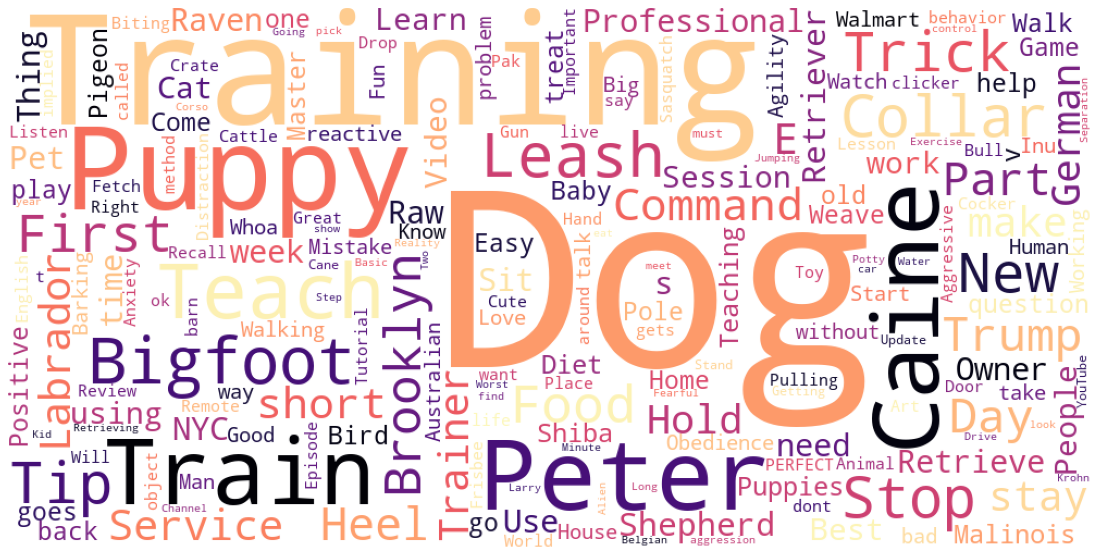

In [310]:
plot_cloud(top_high_wordcloud)

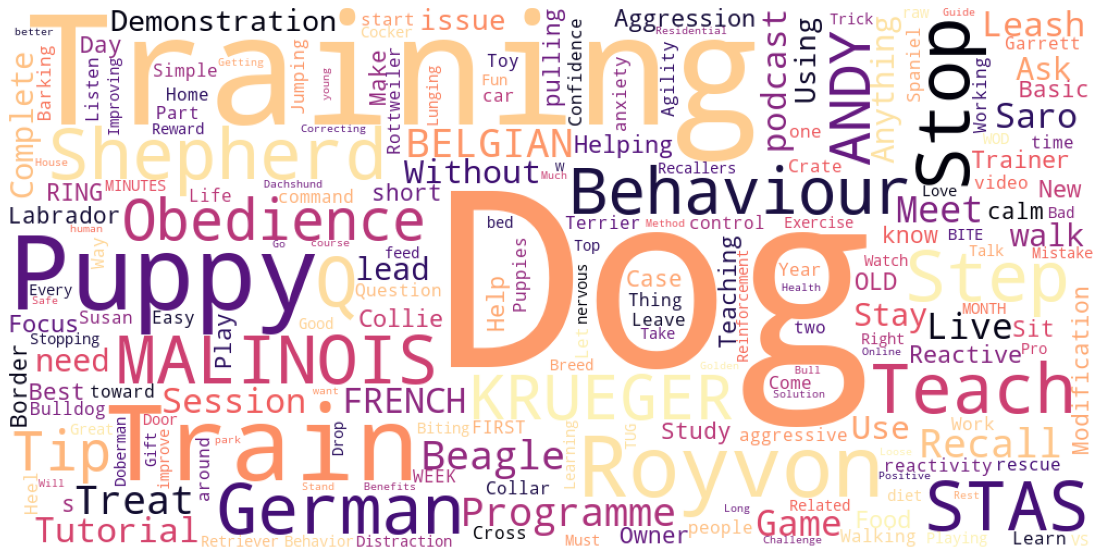

In [311]:
plot_cloud(top_medium_wordcloud)

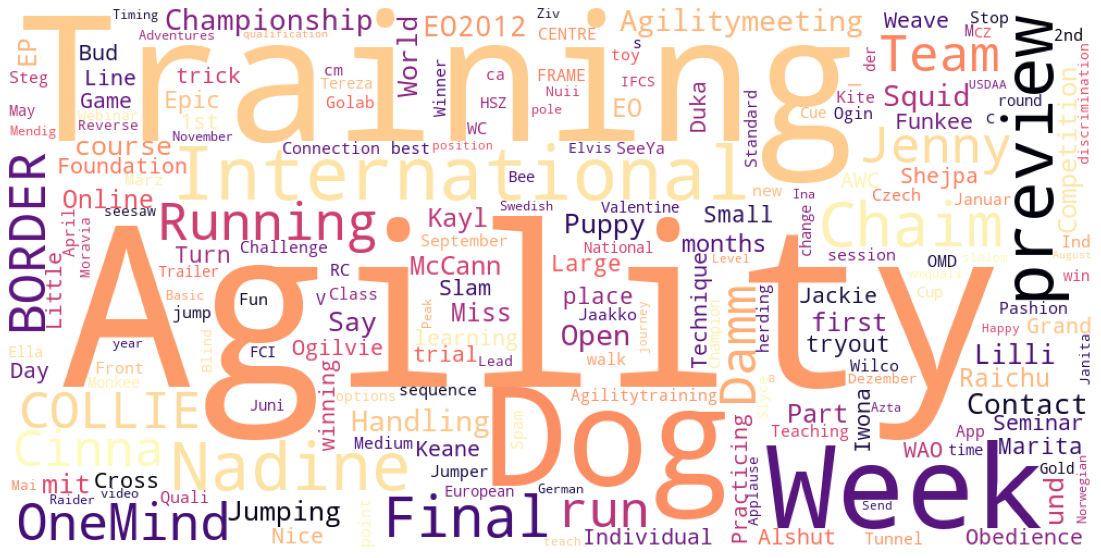

In [312]:
plot_cloud(top_low_wordcloud)

In [299]:
stop_words = set(stopwords.words('english'))

top_high_tag = pd.DataFrame()
top_medium_tag = pd.DataFrame()
top_low_tag = pd.DataFrame()

top_high_tag['tag_no_stopwords'] = top_high['tags_list'].apply(lambda x : [item for item in x if item not in stop_words])
top_medium_tag['tag_no_stopwords'] = top_medium['tags_list'].apply(lambda x : [item for item in x if item not in stop_words])
top_low_tag['tag_no_stopwords'] = top_low['tags_list'].apply(lambda x : [item for item in x if item not in stop_words])

In [300]:
top_high_tags_words = [a for b in top_high_tag['tag_no_stopwords'].tolist() for a in b] #I don't get this
top_medium_tags_words = [a for b in top_medium_tag['tag_no_stopwords'].tolist() for a in b] #I don't get this
top_low_tags_words = [a for b in top_low_tag['tag_no_stopwords'].tolist() for a in b] #I don't get this

In [313]:
top_high_tags_words_str = ' '.join(top_high_tags_words)
top_medium_tags_words_str = ' '.join(top_medium_tags_words)
top_low_tags_words_str = ' '.join(top_low_tags_words)

In [314]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis('off');
    
top_high_tags_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_high_tags_words_str)

top_medium_tags_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_medium_tags_words_str)

top_low_tags_wordcloud = WordCloud(width=1000, 
                      height=500, 
                      random_state=1, 
                      background_color='white',
                      colormap='magma',
                      collocations=False).generate(top_low_tags_words_str)

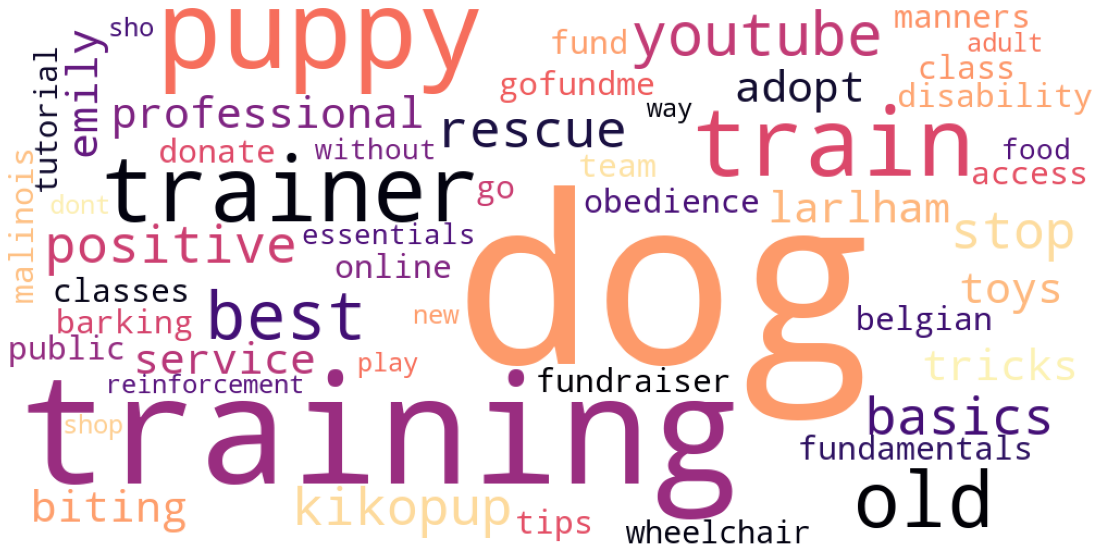

In [315]:
plot_cloud(top_high_tags_wordcloud)

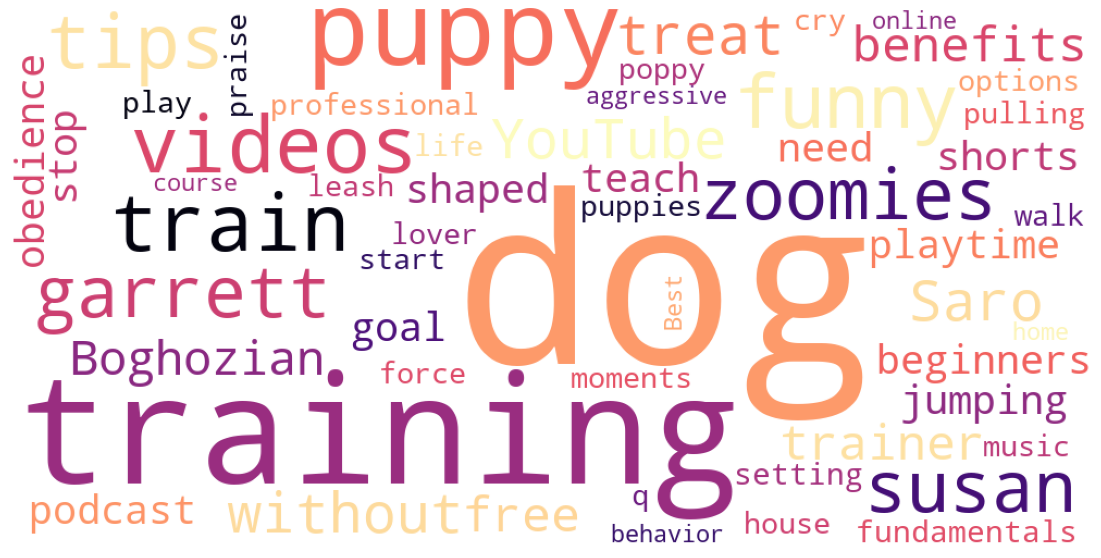

In [316]:
plot_cloud(top_medium_tags_wordcloud)

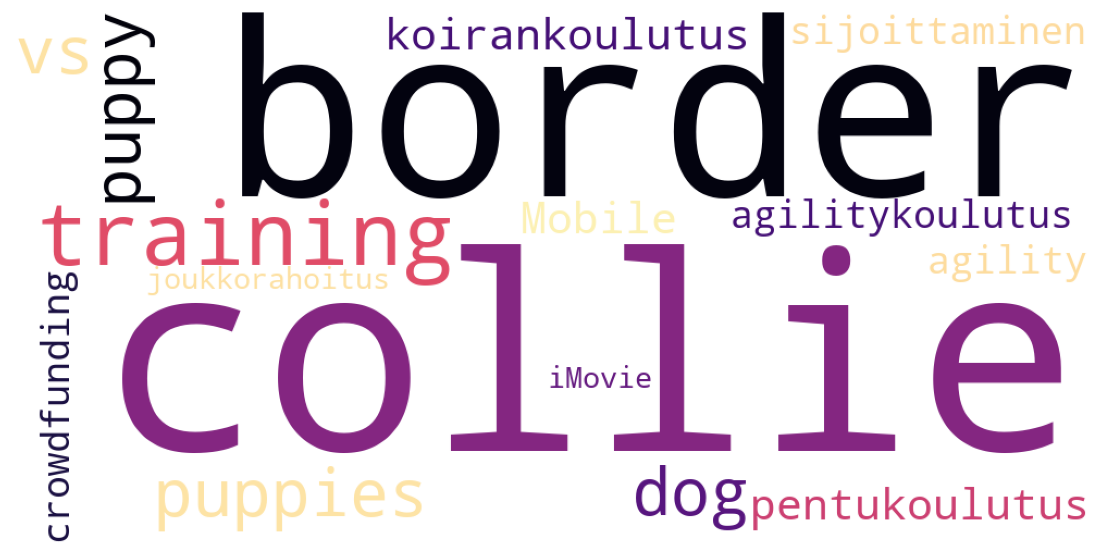

In [317]:
plot_cloud(top_low_tags_wordcloud)